In [1]:
import os
import re
import glob
import yaml

import pandas as pd

import matplotlib.pyplot as plt

import napari

from utils.utility_functions import single_channel_pyramid

In [2]:
# I/O

# read image patch dataframe
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
data = main.sample(frac=1.0)

# import Leiden-clustered single-cell data
df = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# read OME-TIFF, segmentation outlines, and H&E channels
sample = 'CRC-097' 
tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), f'input/{sample}_hema_eosin.ome.tif')

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# get markers excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# isolate antibodies of interest
abx_channels = [
    i for i in df.columns if 'nucleiRingMask' in i
    if 'Hoechst' not in i if i not in markers_to_exclude
]

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

# out dir
out = os.path.join(os.getcwd(), f'output/itreg')
if not os.path.exists(out):
    os.makedirs(out)

VAE4 colored by Seg 13 (blue) and Seg 15 (red)


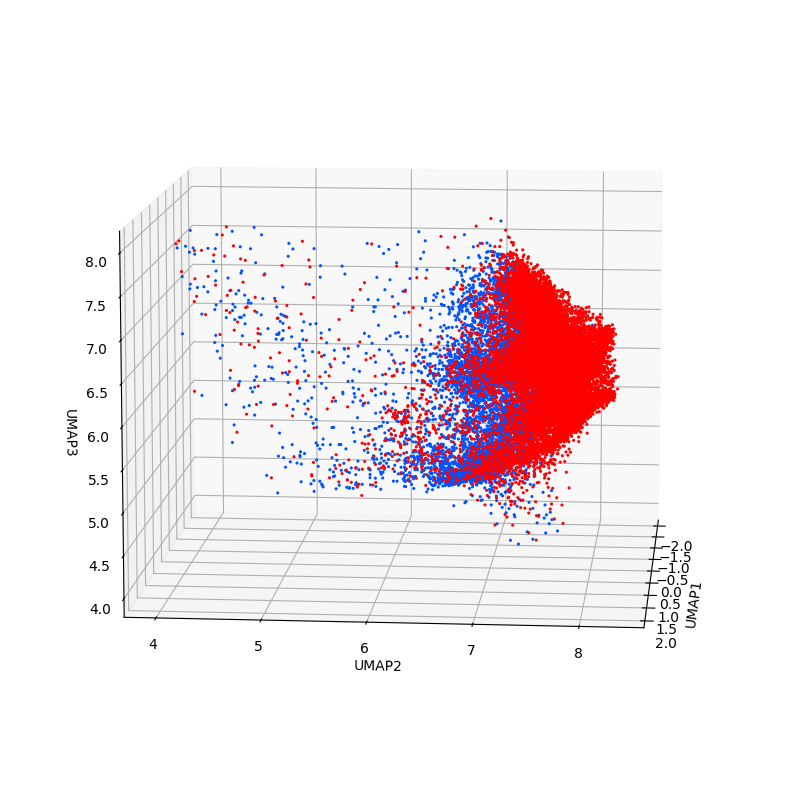

VAE4 colored by FOXP3


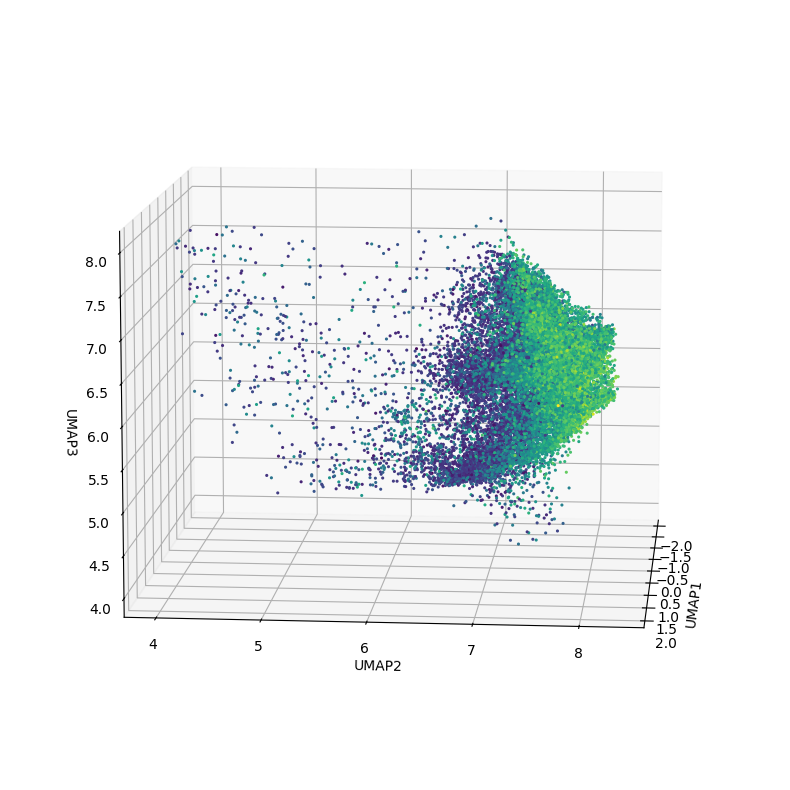

In [3]:
# isolate Tcon/Treg cells from VAE9 clustering and plot
vae = data[data['VAE9_VIG7'] == 4]
vae = vae[(vae['VAE9_VIG7_emb1'] > -2.0) & (vae['VAE9_VIG7_emb1'] < 2.0)]
vae = vae[(vae['VAE9_VIG7_emb2'] > 4.0) & (vae['VAE9_VIG7_emb2'] < 9.0)]
vae = vae[(vae['VAE9_VIG7_emb3'] > 4.0) & (vae['VAE9_VIG7_emb3'] < 8.0)]

print('VAE4 colored by Seg 13 (blue) and Seg 15 (red)')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=5)
ax.scatter(
    vae['VAE9_VIG7_emb1'][vae['Seg'] == 13],
    vae['VAE9_VIG7_emb2'][vae['Seg'] == 13],
    vae['VAE9_VIG7_emb3'][vae['Seg'] == 13],
    color=(0, 0.33, 1), linewidth=0.0, s=5, alpha=1,
)
ax.scatter(
    vae['VAE9_VIG7_emb1'][vae['Seg'] == 15],
    vae['VAE9_VIG7_emb2'][vae['Seg'] == 15],
    vae['VAE9_VIG7_emb3'][vae['Seg'] == 15],
    color=(1.0, 0.0, 0.0), linewidth=0.0, s=5, alpha=1,
)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out, 'V4_by_S13_S15.png'), dpi=800)
plt.show()
plt.close('all')

print('VAE4 colored by FOXP3')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=5)
ax.scatter(
    vae['VAE9_VIG7_emb1'][(vae['Seg'] == 13) | (vae['Seg'] == 15)],
    vae['VAE9_VIG7_emb2'][(vae['Seg'] == 13) | (vae['Seg'] == 15)],
    vae['VAE9_VIG7_emb3'][(vae['Seg'] == 13) | (vae['Seg'] == 15)],
    c=vae['FOXP3_570'][(vae['Seg'] == 13) | (vae['Seg'] == 15)],
    cmap='viridis', linewidth=0.0, s=5, alpha=1
)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out, 'V4_by_FOXP3.png'), dpi=800)
plt.show()
plt.close('all')

Seg13 and Seg 15 colored by cluster label


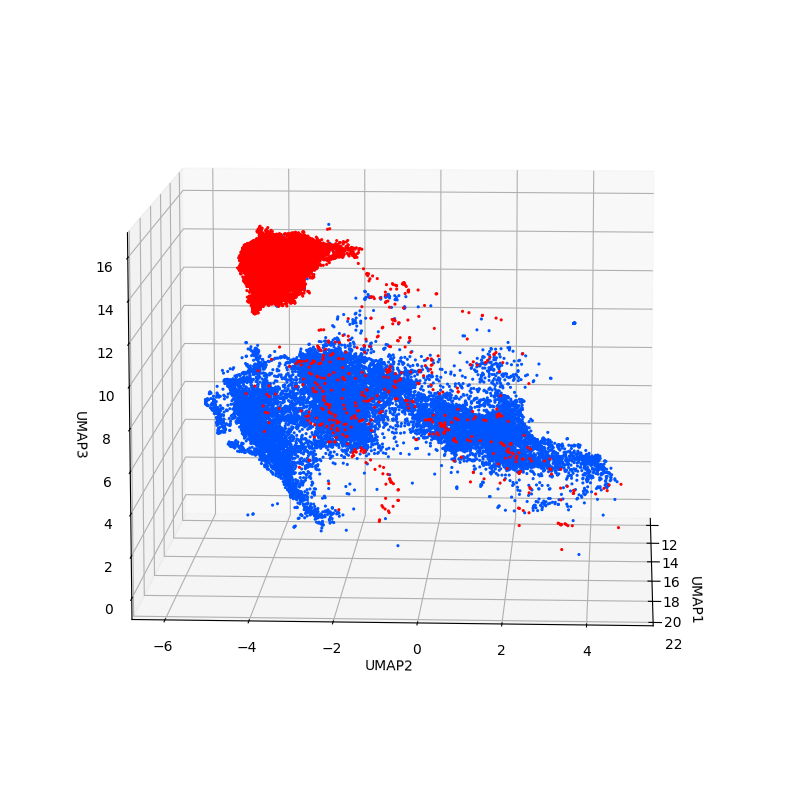

Seg13 and Seg 15 colored by Seg 15 (red) and which cells in Seg 13 overlap (green) or do not overlap (blue) VAE15


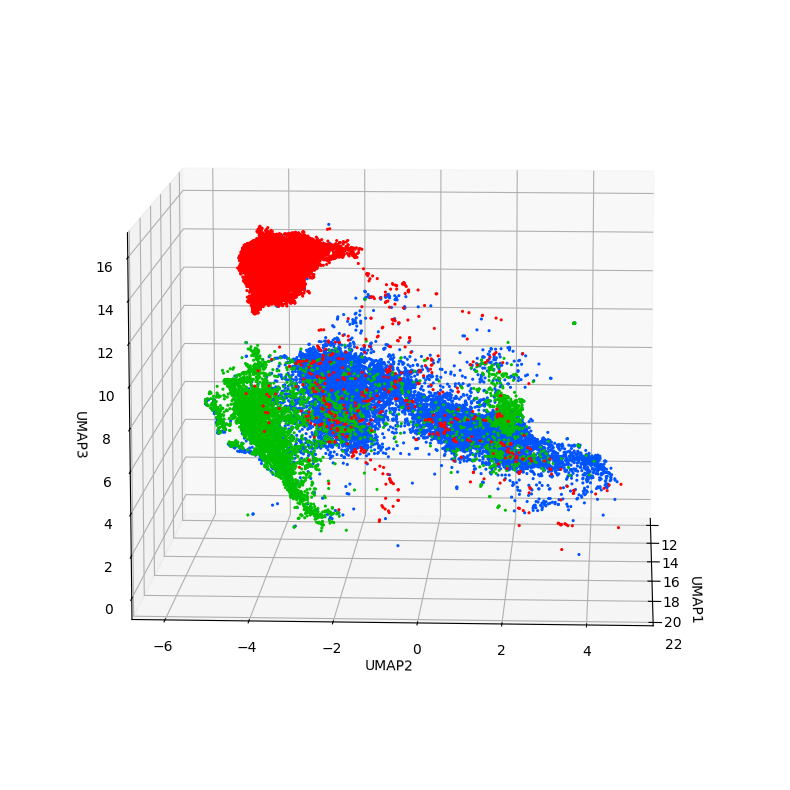

Seg 13 and 15 colored by FOXP3


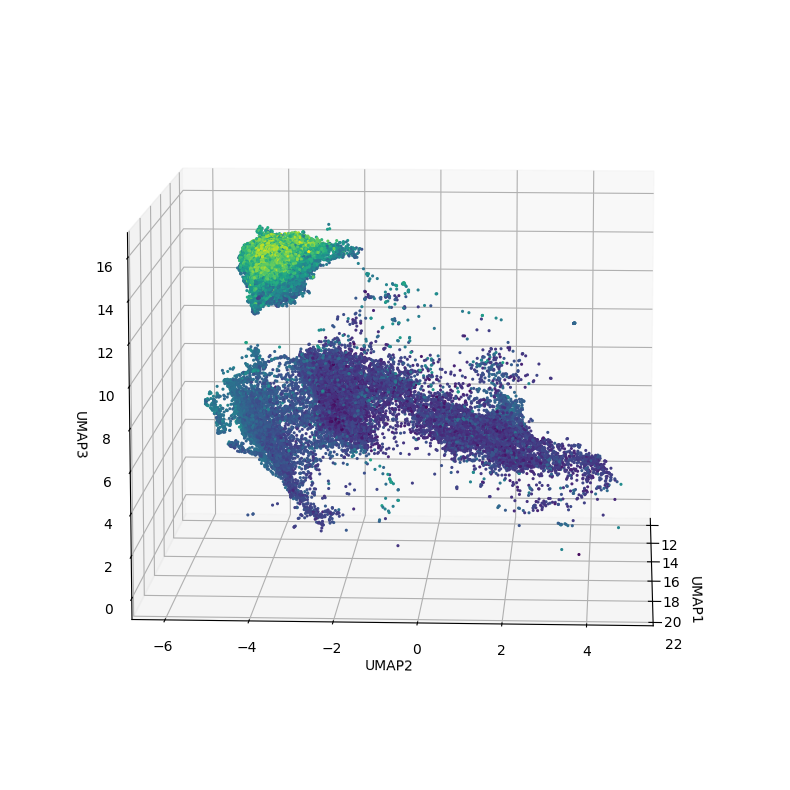

In [4]:
# isolate Tcon/Treg cells from Seg clustering and plot
seg = data[data['Seg'].isin([13, 15])]
seg = seg[(seg['Seg_emb1'] > 10.0) & (seg['Seg_emb1'] < 23.0)]
seg = seg[(seg['Seg_emb2'] > -6.0) & (seg['Seg_emb2'] < 5.0)]
seg = seg[(seg['Seg_emb3'] > 0.0) & (seg['Seg_emb3'] < 16.0)]

print('Seg13 and Seg 15 colored by cluster label')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=3)
ax.scatter(
    seg['Seg_emb1'][seg['Seg'] == 13],
    seg['Seg_emb2'][seg['Seg'] == 13],
    seg['Seg_emb3'][seg['Seg'] == 13],
    color=(0.0, 0.33, 1.0), linewidth=0.0, s=5, alpha=1
)
ax.scatter(
    seg['Seg_emb1'][seg['Seg'] == 15],
    seg['Seg_emb2'][seg['Seg'] == 15],
    seg['Seg_emb3'][seg['Seg'] == 15],
    color=(1.0, 0.0, 0.0), linewidth=0.0, s=5, alpha=1
)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out, 'S13_15.png'), dpi=800)
plt.show()
plt.close('all')

print('Seg13 and Seg 15 colored by Seg 15 (red) and which cells in Seg 13 ' 
      'overlap (green) or do not overlap (blue) VAE15')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=3)
ax.scatter(
    seg['Seg_emb1'][(seg['Seg'] == 13) & (seg['VAE9_VIG7'] != 15)],
    seg['Seg_emb2'][(seg['Seg'] == 13) & (seg['VAE9_VIG7'] != 15)],
    seg['Seg_emb3'][(seg['Seg'] == 13) & (seg['VAE9_VIG7'] != 15)],
    color=(0.0, 0.33, 1.0), linewidth=0.0, s=5, alpha=1
)
ax.scatter(
    seg['Seg_emb1'][(seg['Seg'] == 13) & (seg['VAE9_VIG7'] == 15)],
    seg['Seg_emb2'][(seg['Seg'] == 13) & (seg['VAE9_VIG7'] == 15)],
    seg['Seg_emb3'][(seg['Seg'] == 13) & (seg['VAE9_VIG7'] == 15)],
    color=(0.0, 0.75, 0.0), linewidth=0.0, s=5, alpha=1
)
ax.scatter(
    seg['Seg_emb1'][seg['Seg'] == 15],
    seg['Seg_emb2'][seg['Seg'] == 15],
    seg['Seg_emb3'][seg['Seg'] == 15],
    color=(1.0, 0.0, 0.0), linewidth=0.0, s=5, alpha=1
)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out, 'S13_15_by_V15.png'), dpi=800)
plt.show()
plt.close('all')

print('Seg 13 and 15 colored by FOXP3')
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d', computed_zorder=False) 
ax.view_init(elev=10, azim=3)
ax.scatter(
    seg['Seg_emb1'], seg['Seg_emb2'], seg['Seg_emb3'],
    c=seg['FOXP3_570'], cmap='viridis', linewidth=0.0, s=5, alpha=1
)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.axis('auto')
ax.tick_params(labelsize=10)
ax.grid(True)
plt.tight_layout() 
plt.savefig(os.path.join(out, 'S13_S15_FOXP3.png'), dpi=800)
plt.show()
plt.close('all')

In [5]:
# initialize image viewer
viewer = napari.Viewer()

In [6]:
# loop over antibodies of interest, add to image viewer, and apply contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )
    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False,
        name=ch, contrast_limits=(min, max)
    )

for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

In [7]:
# add centroids to image viewer
# data = seg[(seg['Seg'] == 13) & (seg['VAE9_VIG7'] == 15)]
data1 = vae[(vae['VAE9_VIG7_emb2'] > 8.0)]
data2 = vae[(vae['VAE9_VIG7_emb2'] >= 7.5) & (vae['VAE9_VIG7_emb2'] <= 8.0)]
data3 = vae[(vae['VAE9_VIG7_emb2'] >= 7.0) & (vae['VAE9_VIG7_emb2'] <= 7.5)]
data4 = vae[(vae['VAE9_VIG7_emb2'] >= 6.0) & (vae['VAE9_VIG7_emb2'] <= 7.0)]
data5 = vae[(vae['VAE9_VIG7_emb2'] < 6.0)]
for name, color, i in zip(['>8', '7.5-8', '7.0-7.5', '6-7', '<6'], ['red', 'orange', 'green', 'blue', 'white'], [data1, data2, data3, data4, data5]):
    centroids = i[['Y_centroid', 'X_centroid']]
    viewer.add_points(
        centroids, name=name, face_color=color, edge_color=color, edge_width=0.0,
        size=3.0, opacity=1.0, blending='opaque', visible=True
    )

In [8]:
# add segmentation outlines to image viewer
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False,
    name='segmentation', opacity=0.3
)

<Image layer 'segmentation' at 0x15d742100>

In [9]:
# add DNA1 channel to image viewer
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray', visible=True, opacity=0.8,
    name='DNA1', contrast_limits=(min, max)
)

<Image layer 'DNA1' at 0x15d76a7c0>

In [10]:
# run image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()